In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

In [2]:
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
IMAGE_SHAPE = (5, 127, 127)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5'

In [6]:
args_gen = {
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

In [7]:
train_images = HDF5DataGenerator(src=TRAIN_PATH, label_key='image', **args_gen)
val_images = HDF5DataGenerator(src=VAL_PATH, label_key='image', **args_gen)
test_images = HDF5DataGenerator(src=TEST_PATH, label_key='image', **args_gen)

train_g = HDF5DataGenerator(src=TRAIN_PATH, label_key='g_cmodel_mag', **args_gen)
val_g = HDF5DataGenerator(src=VAL_PATH, label_key='g_cmodel_mag', **args_gen)
test_g = HDF5DataGenerator(src=TEST_PATH, label_key='g_cmodel_mag', **args_gen)

train_r = HDF5DataGenerator(src=TRAIN_PATH, label_key='r_cmodel_mag', **args_gen)
val_r = HDF5DataGenerator(src=VAL_PATH, label_key='r_cmodel_mag', **args_gen)
test_r = HDF5DataGenerator(src=TEST_PATH, label_key='r_cmodel_mag', **args_gen)

train_i = HDF5DataGenerator(src=TRAIN_PATH, label_key='i_cmodel_mag', **args_gen)
val_i = HDF5DataGenerator(src=VAL_PATH, label_key='i_cmodel_mag', **args_gen)
test_i = HDF5DataGenerator(src=TEST_PATH, label_key='i_cmodel_mag', **args_gen)

train_z = HDF5DataGenerator(src=TRAIN_PATH, label_key='z_cmodel_mag', **args_gen)
val_z = HDF5DataGenerator(src=VAL_PATH, label_key='z_cmodel_mag', **args_gen)
test_z = HDF5DataGenerator(src=TEST_PATH, label_key='z_cmodel_mag', **args_gen)

train_y = HDF5DataGenerator(src=TRAIN_PATH, label_key='y_cmodel_mag', **args_gen)
val_y = HDF5DataGenerator(src=VAL_PATH, label_key='y_cmodel_mag', **args_gen)
test_y = HDF5DataGenerator(src=TEST_PATH, label_key='y_cmodel_mag', **args_gen)

train_specz = HDF5DataGenerator(src=TRAIN_PATH, label_key='specz_redshift', **args_gen)
val_specz = HDF5DataGenerator(src=VAL_PATH, label_key='specz_redshift', **args_gen)
test_specz = HDF5DataGenerator(src=TEST_PATH, label_key='specz_redshift', **args_gen)

In [8]:
train_mags = JoinedMags(train_g, train_r, train_i, train_z, train_y)
val_mags = JoinedMags(val_g, val_r, val_i, val_z, val_y)
test_mags = JoinedMags(test_g, test_r, test_i, test_z, test_y)

In [9]:
train_gen = JoinedGen(train_images, train_mags, train_specz)
val_gen = JoinedGen(val_images, val_mags, val_specz)
test_gen = JoinedGen(test_images, test_mags, test_specz)

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_cnn = Input(shape=(5,127,127))
input_nn = Input(shape=(5,))

# CNN
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(2,2), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3,3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(2,2),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = Flatten()(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

# NN
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)

# Concat & Output
concat = Concatenate()([dense3, hidden4])
distribution_params = Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = Model(inputs=[input_cnn, input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 127, 127) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 63, 63)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 63, 63)   8256        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_combined_with_5pool_v7'

checkpoint_filepath = f'/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=val_gen, callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/100
784/784 [==============================] - 859s 573ms/step - loss: 0.2607 - mse: 0.1750 - val_loss: 0.2008 - val_mse: 0.0940

Epoch 00001: loss improved from inf to 0.26066, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 2/100
784/784 [==============================] - 447s 570ms/step - loss: 0.1643 - mse: 0.0942 - val_loss: 0.1554 - val_mse: 0.0818

Epoch 00002: loss improved from 0.26066 to 0.16427, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 3/100
784/784 [==============================] - 443s 566ms/step - loss: 0.1411 - mse: 0.0866 - val_loss: 0.1071 - val_mse: 0.0761

Epoch 00003: loss improved from 0.16427 to 0.14114, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 4/100
784/784 [==============================] - 447s 571ms/step - loss: 0.1193 - mse: 0.0800 - val_loss: 0.0942 - val_mse: 0.0711

Epoch 00004: loss improved from 0.14114 t

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 447s 570ms/step - loss: 0.0374 - mse: 0.0471 - val_loss: 0.0613 - val_mse: 0.0602

Epoch 00024: loss improved from 0.03897 to 0.03736, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 25/100
784/784 [==============================] - 446s 568ms/step - loss: 0.0368 - mse: 0.0453 - val_loss: 0.0609 - val_mse: 0.0565

Epoch 00025: loss improved from 0.03736 to 0.03685, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 26/100
784/784 [==============================] - 492s 628ms/step - loss: 0.0352 - mse: 0.0437 - val_loss: 0.0639 - val_mse: 0.0578

Epoch 00026: loss improved from 0.03685 to 0.03518, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 27/100
784/784 [==============================] - 455s 580ms/step - loss: 0.0331 - mse: 0.0412 - val_loss: 0.0611 - val_mse: 0.0530

Epoch 00027: loss improved from 0.03518 to 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 444s 567ms/step - loss: 0.0260 - mse: 0.0290 - val_loss: 0.0596 - val_mse: 0.0480

Epoch 00035: loss did not improve from 0.02594
Epoch 36/100
784/784 [==============================] - 453s 578ms/step - loss: 0.0235 - mse: 0.0270 - val_loss: 0.0608 - val_mse: 0.0481

Epoch 00036: loss improved from 0.02594 to 0.02348, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 37/100
156/784 [====>.........................] - ETA: 4:59 - loss: 0.0226 - mse: 0.0249

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 443s 565ms/step - loss: 0.0166 - mse: 0.0194 - val_loss: 0.0600 - val_mse: 0.0499

Epoch 00048: loss improved from 0.01696 to 0.01665, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 49/100
784/784 [==============================] - 450s 574ms/step - loss: 0.0158 - mse: 0.0190 - val_loss: 0.0620 - val_mse: 0.0478

Epoch 00049: loss improved from 0.01665 to 0.01582, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 50/100
400/784 [==============>...............] - ETA: 2:56 - loss: 0.0163 - mse: 0.0183

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 529s 674ms/step - loss: 0.0136 - mse: 0.0159 - val_loss: 0.0636 - val_mse: 0.0481

Epoch 00058: loss did not improve from 0.01318
Epoch 59/100
635/784 [=======================>......] - ETA: 1:29 - loss: 0.0130 - mse: 0.0154

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 460s 587ms/step - loss: 0.0124 - mse: 0.0142 - val_loss: 0.0598 - val_mse: 0.0481

Epoch 00063: loss did not improve from 0.01074
Epoch 64/100
784/784 [==============================] - 401s 512ms/step - loss: 0.0113 - mse: 0.0138 - val_loss: 0.0601 - val_mse: 0.0505

Epoch 00064: loss did not improve from 0.01074
Epoch 65/100
784/784 [==============================] - 354s 452ms/step - loss: 0.0107 - mse: 0.0135 - val_loss: 0.0604 - val_mse: 0.0499

Epoch 00065: loss improved from 0.01074 to 0.01074, saving model to /models/HSC_v6_NN_neurips_combined_with_5pool_v7/checkpoints/cp.ckpt
Epoch 66/100
784/784 [==============================] - 395s 504ms/step - loss: 0.0112 - mse: 0.0142 - val_loss: 0.0609 - val_mse: 0.0545

Epoch 00066: loss did not improve from 0.01074
Epoch 67/100
784/784 [==============================] - 508s 648ms/step - loss: 0.0109 - mse: 0.0133 - val_loss: 0.0593 - val_mse: 0.0495

Epoch 00067: loss did not improve from 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 420s 536ms/step - loss: 0.0079 - mse: 0.0101 - val_loss: 0.0615 - val_mse: 0.0529

Epoch 00091: loss did not improve from 0.00704
Epoch 92/100
784/784 [==============================] - 430s 548ms/step - loss: 0.0083 - mse: 0.0104 - val_loss: 0.0589 - val_mse: 0.0509

Epoch 00092: loss did not improve from 0.00704
Epoch 93/100
 89/784 [==>...........................] - ETA: 4:51 - loss: 0.0073 - mse: 0.0099

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - 426s 543ms/step - loss: 0.0083 - mse: 0.0101 - val_loss: 0.0590 - val_mse: 0.0505

Epoch 00099: loss did not improve from 0.00685
Epoch 100/100
784/784 [==============================] - 424s 541ms/step - loss: 0.0073 - mse: 0.0093 - val_loss: 0.0587 - val_mse: 0.0502

Epoch 00100: loss did not improve from 0.00685


In [16]:
model.load_weights(checkpoint_filepath)

In [17]:
pred = model.predict(test_gen)

In [18]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

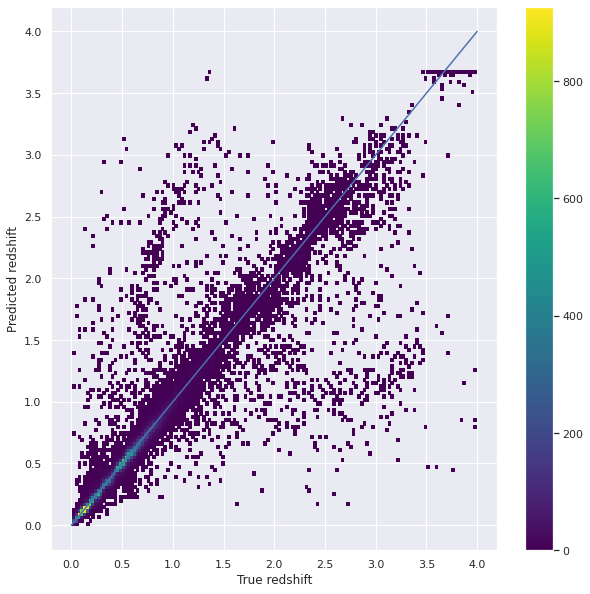

In [19]:
plot_predictions(np.ravel(pred), y_test)

In [20]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [21]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.056493,-0.003068,-0.002888,0.022439,0.019606,0.126397,0.033636,0.045957


In [22]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/predictions/{model_name}/testing_metrics.csv', index=False)

In [23]:
# # load weights instead
# evaluated_model = model([X_test, test_images])

In [24]:
# photoz = []
# for i in range(0,len(X_test)):
#     pred = model([X_test[i], test_images[i]])
#     photoz.append(pred)

In [25]:
# mean_arr = evaluated_model.mean().numpy()
# std_arr = evaluated_model.stddev().numpy()

In [26]:
# y_pred = np.ravel(mean_arr) # to make ndim = 1
# y_pred

In [27]:
# plot_predictions(y_pred, y_test)

In [28]:
# metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test))

In [29]:
# metrics

In [30]:
# df = pd.DataFrame(y_pred, columns=['photoz'])
# df['photz_err'] = np.ravel(std_arr)
# df['specz'] = y_test
# df['object_id'] = OID_test
# if os.path.exists(f'/predictions/{model_name}') == False:
#     os.makedirs(f'/predictions/{model_name}')
    
# df.to_csv(f'/predictions/{model_name}/testing_predictions.csv', index=False)

In [31]:
# if os.path.exists(f'predictions/{model_name}') ==  False:
#     os.makedirs(f'predictions/{model_name}')
    
# metrics.to_csv(f'/predictions/{model_name}/testing_metrics.csv', index=False)

In [32]:
# y_train

In [33]:
# v1 batch_size = 256
# v2 batch_size = None
# v4 uses DataMaker+, batch size of 512, 10 epochs, dropout(0.3) model might be overfitting